In [1]:
pip install opencv-python albumentations tqdm pyyaml scikit-learn ultralytics easyocr lapx

  Using cached torchvision-0.24.1-cp310-cp310-win_amd64.whl (3.7 MB)
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.21.0+cu124
    Uninstalling torchvision-0.21.0+cu124:
      Successfully uninstalled torchvision-0.21.0+cu124
Note: you may need to restart the kernel to use updated packages.


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch-directml 0.2.5.dev240914 requires torch==2.4.1, but you have torch 2.9.1 which is incompatible.
torch-directml 0.2.5.dev240914 requires torchvision==0.19.1, but you have torchvision 0.24.1 which is incompatible.
You should consider upgrading via the 'c:\Users\Admin\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [5]:
import os
import cv2
import glob
import shutil
import zipfile
import albumentations as A
from tqdm import tqdm

# --- CONFIGURATION ---
INPUT_PATH = "archive.zip"  
OUTPUT_DIR = "augmented_plates"
MULTIPLIER = 1   # 1 Original + 1 Augmented = 2x Total Data (4k -> 8k)

# --- SAFE AUGMENTATION PIPELINE ---
def get_train_transforms():
    return A.Compose([
        # NO GEOMETRY CHANGES (Boxes stay perfect)
        
        # 1. LIGHTING & COLOR (Crucial for day/night/shadows)
        A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
        A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=20, val_shift_limit=10, p=0.5),

        # 2. CAMERA NOISE & BLUR (Simulates movement/bad cameras)
        A.GaussNoise(var_limit=(5.0, 15.0), p=0.25),
        A.MotionBlur(blur_limit=5, p=0.3),
        A.ISONoise(p=0.2),
    ],
    # We still need BboxParams to pass the boxes through, even if they don't move
    bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels'], min_visibility=0.3))

def main():
    base_dir = os.getcwd()
    full_input_path = os.path.join(base_dir, INPUT_PATH)
    full_output_path = os.path.join(base_dir, OUTPUT_DIR)
    
    # 1. SETUP & EXTRACT (Same as before)
    print("--- 1. Data Setup ---")
    working_data_path = ""
    is_temp_extraction = False

    if not os.path.exists(full_input_path):
        print(f"❌ Error: '{INPUT_PATH}' not found.")
        return

    if zipfile.is_zipfile(full_input_path):
        print(f"Extracting '{INPUT_PATH}'...")
        extract_path = os.path.join(base_dir, "temp_extracted_data")
        if os.path.exists(extract_path): shutil.rmtree(extract_path)
        os.makedirs(extract_path, exist_ok=True)
        with zipfile.ZipFile(full_input_path, 'r') as z: z.extractall(extract_path)
        working_data_path = extract_path
        is_temp_extraction = True
    elif os.path.isdir(full_input_path):
        working_data_path = full_input_path
    
    # 2. LOCATE FILES
    image_files = []
    for ext in ['*.jpg', '*.jpeg', '*.png', '*.bmp']:
        image_files.extend(glob.glob(os.path.join(working_data_path, '**', ext), recursive=True))

    print(f"Found {len(image_files)} images.")

    # Prepare Output
    if os.path.exists(full_output_path): shutil.rmtree(full_output_path)
    os.makedirs(os.path.join(full_output_path, "images"))
    os.makedirs(os.path.join(full_output_path, "labels"))

    # Copy yaml
    yaml_files = glob.glob(os.path.join(working_data_path, "**", "*.y*ml"), recursive=True)
    if yaml_files: shutil.copy(yaml_files[0], os.path.join(full_output_path, "dataset.yaml"))

    # 3. RUN AUGMENTATION
    transform = get_train_transforms()
    print(f"Generating 1 augmented version per image...")

    augmented_count = 0

    for img_path in tqdm(image_files, desc="Processing"):
        filename = os.path.basename(img_path)
        name, ext = os.path.splitext(filename)

        # Find Label
        label_path = img_path.replace("images", "labels").replace(ext, ".txt")
        if not os.path.exists(label_path): label_path = img_path.replace(ext, ".txt")
        if not os.path.exists(label_path): continue

        image = cv2.imread(img_path)
        if image is None: continue

        # Parse Labels
        bboxes, class_labels = [], []
        try:
            with open(label_path, 'r') as f:
                for line in f:
                    parts = line.strip().split()
                    if len(parts) >= 5:
                        bboxes.append([float(x) for x in parts[1:5]])
                        class_labels.append(int(parts[0]))
        except: continue
        
        if not bboxes: continue

        # SAVE ORIGINAL (Version 0)
        cv2.imwrite(os.path.join(full_output_path, "images", filename), image)
        shutil.copy(label_path, os.path.join(full_output_path, "labels", f"{name}.txt"))

        # SAVE AUGMENTED (Version 1 - Blur/Noise only)
        # We only loop once since MULTIPLIER = 1
        try:
            aug = transform(image=image, bboxes=bboxes, class_labels=class_labels)
            
            new_name = f"{name}_aug"
            cv2.imwrite(os.path.join(full_output_path, "images", f"{new_name}{ext}"), aug['image'])

            with open(os.path.join(full_output_path, "labels", f"{new_name}.txt"), 'w') as f:
                for cls, bbox in zip(aug['class_labels'], aug['bboxes']):
                    # Boxes barely change, but we maintain the format
                    bx, by, bw, bh = [min(max(x, 0.0), 1.0) for x in bbox]
                    f.write(f"{cls} {bx:.6f} {by:.6f} {bw:.6f} {bh:.6f}\n")
            
            augmented_count += 1
        except:
            pass

    # 4. CLEANUP
    if is_temp_extraction and os.path.exists(working_data_path):
        shutil.rmtree(working_data_path)

    print(f"\n--- Done ---")
    print(f"Originals: {len(image_files)}")
    print(f"Augmented: {augmented_count}")
    print(f"Total Dataset Size: {len(image_files) + augmented_count}")

if __name__ == "__main__":
    main()

--- 1. Data Setup ---
Extracting 'archive.zip'...


C:\Users\Admin\AppData\Local\Temp\ipykernel_7864\2310855425.py:24: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(5.0, 15.0), p=0.25),


Found 4578 images.
Generating 1 augmented version per image...


Processing: 100%|██████████| 4578/4578 [02:29<00:00, 30.72it/s]



--- Done ---
Originals: 4578
Augmented: 2734
Total Dataset Size: 7312


In [8]:
import os
import glob
import shutil
import random
import yaml
from sklearn.model_selection import train_test_split
from tqdm import tqdm  # <--- CHANGED THIS LINE to use standard text bar

# --- CONFIGURATION ---
INPUT_FOLDER = "augmented_plates"       
OUTPUT_FOLDER = "yolo_dataset_final"    
VAL_SPLIT = 0.2                         
OUTPUT_ZIP_NAME = "yolo_dataset_final.zip"

def process_label(src_path, dst_path):
    """
    Reads a label file, forces class ID to '0', and saves to destination.
    """
    with open(src_path, 'r') as f:
        lines = f.readlines()

    new_lines = []
    for line in lines:
        parts = line.strip().split()
        if len(parts) >= 5:
            # Force class ID (first item) to '0'
            parts[0] = '0'
            new_lines.append(" ".join(parts) + "\n")

    # Write the clean data to the new location
    with open(dst_path, 'w') as f:
        f.writelines(new_lines)

def smart_split_and_fix():
    base_dir = os.getcwd()
    full_input_path = os.path.join(base_dir, INPUT_FOLDER)
    full_output_path = os.path.join(base_dir, OUTPUT_FOLDER)

    if not os.path.exists(full_input_path):
        print(f"❌ Error: Input folder '{INPUT_FOLDER}' not found.")
        print(f"   Looking in: {base_dir}")
        return False

    # 1. Identify Unique "Scenes"
    img_files = glob.glob(os.path.join(full_input_path, "images", "*"))
    unique_names = set()
    file_map = {}

    print("🔍 Grouping files by scene...")
    for file_path in img_files:
        filename = os.path.basename(file_path)
        
        if "_aug_" in filename:
            base_name = filename.split("_aug_")[0]
        else:
            base_name = os.path.splitext(filename)[0]

        unique_names.add(base_name)
        if base_name not in file_map:
            file_map[base_name] = []
        file_map[base_name].append(file_path)

    unique_list = list(unique_names)
    print(f"✅ Found {len(unique_list)} unique scenes.")

    if len(unique_list) == 0:
        print("❌ Error: No scenes found. Check your input folder.")
        return False

    # 2. Split Scenes
    train_names, val_names = train_test_split(unique_list, test_size=VAL_SPLIT, random_state=42)

    # 3. Create Folder Structure
    dirs = [
        (train_names, "train"),
        (val_names, "val")
    ]

    if os.path.exists(full_output_path):
        shutil.rmtree(full_output_path)

    for _, split_name in dirs:
        os.makedirs(os.path.join(full_output_path, split_name, "images"), exist_ok=True)
        os.makedirs(os.path.join(full_output_path, split_name, "labels"), exist_ok=True)

    # 4. Process Files
    print(f"🚀 Processing and fixing labels...")

    for names_list, split_name in dirs:
        # Using standard tqdm here avoids the IProgress error
        for name in tqdm(names_list, desc=f"Processing {split_name}"):
            for img_path in file_map[name]:
                # --- Handle Image ---
                src_img = img_path
                basename = os.path.basename(img_path)
                dst_img = os.path.join(full_output_path, split_name, "images", basename)
                shutil.copy(src_img, dst_img)

                # --- Handle Label ---
                name_no_ext = os.path.splitext(basename)[0]
                label_name = name_no_ext + ".txt"
                
                src_lbl = os.path.join(full_input_path, "labels", label_name)
                dst_lbl = os.path.join(full_output_path, split_name, "labels", label_name)

                if os.path.exists(src_lbl):
                    process_label(src_lbl, dst_lbl)

    # 5. Create data.yaml
    yaml_content = {
        'path': full_output_path,
        'train': 'train/images',
        'val': 'val/images',
        'nc': 1,
        'names': ['plate']
    }

    with open(os.path.join(full_output_path, 'data.yaml'), 'w') as f:
        yaml.dump(yaml_content, f)

    print(f"\n✅ Dataset built at: {OUTPUT_FOLDER}")
    return True

smart_split_and_fix()

🔍 Grouping files by scene...
✅ Found 7306 unique scenes.
🚀 Processing and fixing labels...


Processing val: 100%|██████████| 1462/1462 [00:04<00:00, 297.27it/s]


✅ Dataset built at: yolo_dataset_final


True

In [9]:
import os
from ultralytics import YOLO

HOME = os.getcwd()
DATA_YAML = os.path.join(HOME, 'yolo_dataset_final', 'data.yaml')
PROJECT_DIR = os.path.join(HOME, 'runs', 'detect')

model = YOLO('yolov8s.pt') # Small model is great for plates

print("🚀 Starting Training (Tight Boxes + Shuffle)...")

results = model.train(
    data=DATA_YAML,
    device=0,             # Uses your RTX 4060
    rect=False,           # ALLOWS SHUFFLING (Critical for stability)
    imgsz=512,
    epochs=50,            # 50 is enough since your previous run peaked at epoch 63
    patience=10,
    batch=16,
    workers=4,
    project=PROJECT_DIR,
    name='plateDetector_Final',
    exist_ok=True,
    mosaic=1.0,           # Augmentation strength
    degrees=0.0,          # We already rotated in the first step, so keep this low/zero
)

🚀 Starting Training (Tight Boxes + Shuffle)...
Ultralytics 8.3.235  Python-3.10.0 torch-2.6.0+cu124 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=c:\Users\Admin\Downloads\cs\yolo_dataset_final\data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=512, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=plateDetector_Final, nbs=64, nms=False, opse

✅ Loading model...
🔍 Testing on 3 random images...

--- Testing: greenpack_1087_aug.png ---


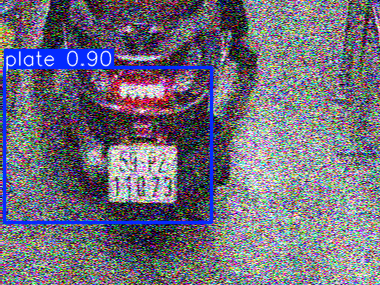



--- Testing: Tgmt_0888_aug.png ---


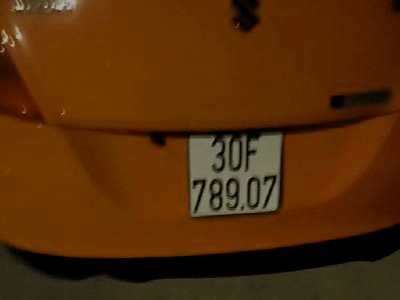



--- Testing: Tgmt_0563.png ---


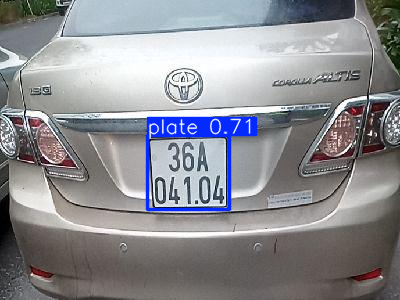

In [22]:
import os
import random
import glob
import cv2
from ultralytics import YOLO
from PIL import Image
from IPython.display import display # <--- Native notebook display tool

# --- CONFIGURATION ---
HOME = os.getcwd()
# Update this path if needed!
MODEL_PATH = os.path.join(HOME, 'runs', 'detect', 'plateDetector_Final', 'weights', 'best.pt')
IMAGE_SOURCE_DIR = os.path.join(HOME, 'yolo_dataset_final', 'val', 'images')
NUM_SAMPLES = 3

# --- MAIN SCRIPT ---
if not os.path.exists(MODEL_PATH):
    print(f"❌ Error: Model not found at: {MODEL_PATH}")
else:
    print(f"✅ Loading model...")
    model = YOLO(MODEL_PATH)

    # Find images
    extensions = ['*.jpg', '*.jpeg', '*.png', '*.bmp']
    image_files = []
    for ext in extensions:
        image_files.extend(glob.glob(os.path.join(IMAGE_SOURCE_DIR, ext)))

    if not image_files:
        print(f"❌ No images found in {IMAGE_SOURCE_DIR}")
    else:
        # Pick random samples
        selected_files = random.sample(image_files, min(len(image_files), NUM_SAMPLES))
        print(f"🔍 Testing on {len(selected_files)} random images...\n")

        for img_file in selected_files:
            print(f"--- Testing: {os.path.basename(img_file)} ---")

            # Run Inference
            results = model.predict(source=img_file, save=False, conf=0.5, verbose=False)

            for result in results:
                # 1. Get the plotted image (BGR format)
                res_plotted = result.plot()
                
                # 2. Convert to RGB
                res_rgb = cv2.cvtColor(res_plotted, cv2.COLOR_BGR2RGB)

                # 3. Show using Native Display (No Matplotlib)
                # This creates a proper image object that VS Code renders immediately
                display(Image.fromarray(res_rgb))
                print("\n")

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


⏳ Loading EasyOCR...
⏳ Loading YOLO...

🚀 RUNNING CORRECTED LAYOUT PIPELINE (3 images)...

📄 Read: E
   Type: UNKNOWN | Status: ⚠️ SUSPICIOUS (0.20)


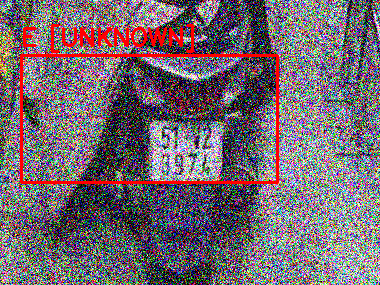

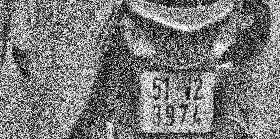

------------------------------
📄 Read: 72H73227
   Type: BIKE | Status: ✅ VALID (0.92)


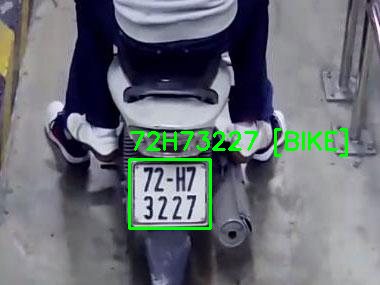

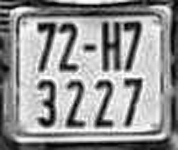

------------------------------
📄 Read: FF
   Type: UNKNOWN | Status: ⚠️ SUSPICIOUS (0.02)


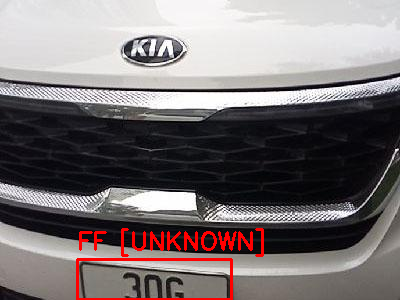

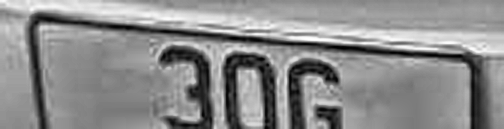

------------------------------


In [8]:
import cv2
import numpy as np
import glob
import os
import random
import re
from ultralytics import YOLO
import easyocr
from PIL import Image
from IPython.display import display

# ==========================================
# 0. CONFIGURATION
# ==========================================
HOME = os.getcwd()
MODEL_PATH = os.path.join(HOME, 'runs', 'detect', 'plateDetector_Final', 'weights', 'best.pt')
TEST_IMAGE_DIR = os.path.join(HOME, 'yolo_dataset_final', 'val', 'images')
NUM_SAMPLES = 5

print("⏳ Loading EasyOCR...")
reader = easyocr.Reader(['en'], gpu=True) 
STRICT_CHARS = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ-.'

print(f"⏳ Loading YOLO...")
detector = YOLO(MODEL_PATH)

# ==========================================
# 1. SMART LOGIC
# ==========================================
VALID_PROVINCES = {
    '11','12','14','15','16','17','18','19','20','21','22','23','24','25','26','27','28','29','30',
    '31','32','33','34','35','36','37','38','43','47','48','49','50','51','52','53','54','55','56',
    '57','58','59','60','61','62','63','64','65','66','67','68','69','70','71','72','73','74','75',
    '76','77','78','79','81','82','83','84','85','86','88','89','90','92','93','94','95','97','98','99'
}

def force_char_type(char, target_type):
    char = char.upper()
    l2n = {'O': '0', 'I': '1', 'J': '3', 'L': '4', 'G': '6', 'S': '5', 'Z': '2', 'B': '8', 'Q': '0', 'D': '0'}
    n2l = {'0': 'O', '1': 'I', '2': 'Z', '5': 'S', '8': 'B', '6': 'G', '4': 'L'}
    
    if target_type == "NUMBER": return l2n.get(char, char)
    if target_type == "LETTER": return n2l.get(char, char)
    return char

def clean_text(text):
    return re.sub(r'[^A-Z0-9]', '', text.upper())

def classify_vehicle_by_layout(sorted_res):
    """
    Distinguishes Rect Car vs Square Car vs Bike based on text structure.
    """
    lines = [clean_text(item[1]) for item in sorted_res if len(clean_text(item[1])) > 1]
    
    # CASE 1: Single Line -> RECTANGULAR CAR
    if len(lines) == 1:
        return "CAR_RECT"
        
    # CASE 2: Multi-Line -> SQUARE PLATE
    if len(lines) >= 2:
        top_row = lines[0]
        # Square Car: "51D" (Usually 3 chars)
        if len(top_row) <= 3:
            return "CAR_SQUARE" 
        # Bike: "59X1" (Usually 4 chars)
        else:
            return "BIKE"
            
    return "UNKNOWN"

def extract_pattern(text, veh_type):
    clean = clean_text(text)
    
    # Define valid lengths
    valid_lens = []
    if veh_type == "BIKE": 
        valid_lens = [8, 9]      # Bikes are longer
    elif "CAR" in veh_type: 
        valid_lens = [7, 8]      # Cars (Square or Rect) are shorter
    else: 
        valid_lens = [7, 8, 9]   # Fallback
    
    if len(clean) in valid_lens: return clean
    
    # Sliding Window Search
    best_candidate = None
    for length in valid_lens:
        for i in range(len(clean) - length + 1):
            candidate = clean[i : i+length]
            
            p1 = force_char_type(candidate[0], "NUMBER")
            p2 = force_char_type(candidate[1], "NUMBER")
            if (p1 + p2) in VALID_PROVINCES:
                if best_candidate is None or len(candidate) > len(best_candidate):
                    best_candidate = candidate
                    
    return best_candidate if best_candidate else clean

def validate_and_fix(text, veh_type):
    # 1. EXTRACT
    clean = extract_pattern(text, veh_type)
    chars = list(clean)
    
    # 2. LENGTH CHECK
    if veh_type == "BIKE":
        if len(chars) not in [8, 9]: return False, clean
    elif "CAR" in veh_type:
        if len(chars) not in [7, 8]: return False, clean
    else:
        if len(chars) not in [7, 8, 9]: return False, clean

    # 3. FORCE POSITIONS (Surgical Repair)
    # Positions 0,1 are ALWAYS Numbers
    chars[0] = force_char_type(chars[0], "NUMBER")
    chars[1] = force_char_type(chars[1], "NUMBER")
    
    # Position 2 is ALWAYS Letter
    chars[2] = force_char_type(chars[2], "LETTER")
    
    # Positions 3+ are ALWAYS Numbers
    for i in range(3, len(chars)):
        chars[i] = force_char_type(chars[i], "NUMBER")
        
    final_text = "".join(chars)
    
    # 4. PROVINCE CHECK
    if final_text[:2] not in VALID_PROVINCES: return False, final_text
    
    return True, final_text

# ==========================================
# 2. PIPELINE
# ==========================================
def preprocess_image(img):
    h, w = img.shape[:2]
    if h < 64: scale = 3 
    elif h < 128: scale = 2
    else: scale = 1
    
    if scale > 1:
        img = cv2.resize(img, None, fx=scale, fy=scale, interpolation=cv2.INTER_CUBIC)
        
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    return clahe.apply(gray)

def get_crop(image, box, pad_h=0.0, pad_w=0.0):
    x1, y1, x2, y2 = map(int, box)
    h_img, w_img = image.shape[:2]
    w_box, h_box = x2 - x1, y2 - y1
    px = int(w_box * pad_w); py = int(h_box * pad_h)
    nx1 = max(0, x1 - px); ny1 = max(0, y1 - py)
    nx2 = min(w_img, x2 + px); ny2 = min(h_img, y2 + py)
    return image[ny1:ny2, nx1:nx2]

def run_pipeline(num_samples):
    all_images = glob.glob(os.path.join(TEST_IMAGE_DIR, "*.jpg")) + \
                 glob.glob(os.path.join(TEST_IMAGE_DIR, "*.png"))
    if not all_images: return
    sample_images = random.sample(all_images, min(len(all_images), num_samples))
    
    print(f"\n🚀 RUNNING CORRECTED LAYOUT PIPELINE ({len(sample_images)} images)...\n")

    for path in sample_images:
        img = cv2.imread(path)
        if img is None: continue

        results = detector.predict(img, conf=0.5, verbose=False)
        if not results[0].boxes: continue

        for box_data in results[0].boxes:
            box = box_data.xyxy[0].cpu().numpy()
            
            # Simple geometric check for cropping strategies
            w_box = box[2] - box[0]
            h_box = box[3] - box[1]
            is_likely_square = (w_box / h_box) < 2.0

            crops_to_try = [get_crop(img, box, pad_h=0.05, pad_w=0.05)]
            if is_likely_square: 
                crops_to_try.append(get_crop(img, box, pad_h=0.15, pad_w=0.1))

            final_text = "FAILED"
            status = "❌ FAILED"
            veh_type = "UNKNOWN"
            best_conf = 0.0
            
            for crop in crops_to_try:
                processed = preprocess_image(crop)
                
                try:
                    result = reader.readtext(processed, detail=1, allowlist=STRICT_CHARS, mag_ratio=2)
                except: continue
                
                if result:
                    # 1. SORT
                    sorted_res = sorted(result, key=lambda item: item[0][0][1])
                    
                    # 2. CLASSIFY (Square Car vs Bike vs Rect Car)
                    veh_type = classify_vehicle_by_layout(sorted_res)
                    
                    # 3. MERGE
                    raw_text = "".join([item[1] for item in sorted_res])
                    conf = sum([item[2] for item in sorted_res]) / len(sorted_res)
                    
                    # 4. VALIDATE & EXTRACT
                    is_valid, fixed = validate_and_fix(raw_text, veh_type)
                    
                    if is_valid:
                        final_text = fixed
                        status = f"✅ VALID ({conf:.2f})"
                        best_conf = conf
                        break 
                    
                    if len(fixed) > len(final_text) or conf > best_conf:
                        final_text = fixed
                        status = f"⚠️ SUSPICIOUS ({conf:.2f})"
                        best_conf = conf

            color = (0, 255, 0) if "VALID" in status else (0, 0, 255)
            cv2.rectangle(img, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), color, 2)
            label = f"{final_text} [{veh_type}]"
            cv2.putText(img, label, (int(box[0]), int(box[1])-10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2)
            
            print(f"📄 Read: {final_text}")
            print(f"   Type: {veh_type} | Status: {status}")
            
            display(Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)))
            display(Image.fromarray(processed))
            print("-" * 30)

run_pipeline(3)

In [ ]:
import cv2
import numpy as np
import re
import os
import csv
import difflib
from ultralytics import YOLO
import easyocr
from tqdm import tqdm
from collections import defaultdict

# --- CẤU HÌNH ---
MODEL_PATH = "runs/detect/plateDetector_Final/weights/best.pt"
INPUT_VIDEO = "./hanoi2.mp4"
OUTPUT_VIDEO = "final_perfect.mp4"
DATA_LOG = "final_results.csv"
DEBUG_DIR = "debug_plates"

if not os.path.exists(DEBUG_DIR):
    os.makedirs(DEBUG_DIR)

CONF_THRESHOLD = 0.5 
OCR_ALLOWLIST = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ-.'

VALID_PROVINCES = [
    '11','12','14','15','16','17','18','19','20','21','22','23','24','25',
    '26','27','28','29','30','31','32','33','34','35','36','37','38','40','41','43',
    '47','48','49','50','51','52','53','54','55','56','57','58','59','60',
    '61','62','63','64','65','66','67','68','69','70','71','72','73','74',
    '75','76','77','78','79','80','81','82','83','84','85','86','88','89','90',
    '92','93','94','95','97','98','99'
]

# --- LOGIC SỬA LỖI ---

def get_char_mapping(char, target_type):
    # Mapping Số
    to_digit = {
        'O': '0', 'D': '0', 'Q': '0', 'U': '0', 'C': '0', 
        'I': '1', 'L': '1', 'T': '1', '/': '1', '|': '1', 'J': '1',
        'Z': '2', 'S': '5', 'G': '6', 'B': '8', 'A': '4', 'F': '8', 
        'E': '8', 'H': '4'
    }
    
    # Mapping Chữ
    to_letter = {
        '0': 'D', '6': 'G', '8': 'B', '5': 'S', '2': 'Z', '1': 'L', 
        '4': 'A', '7': 'T',
        'U': 'L' # <--- THÊM LUẬT: Thấy U đổi thành L ngay trong từ điển mapping
    }
    
    if target_type == "DIGIT":
        return to_digit.get(char, char)
    elif target_type == "LETTER":
        return to_letter.get(char, char)
    return char

def smart_correction(text):
    # Clean text
    clean = re.sub(r'[^A-Z0-9]', '', text.upper())
    chars = list(clean)
    n = len(chars)
    
    if n < 7 or n > 10: return None
    
    # 1. VÙNG MÃ TỈNH (2 ký tự đầu) -> ÉP VỀ SỐ
    p1 = get_char_mapping(chars[0], "DIGIT")
    p2 = get_char_mapping(chars[1], "DIGIT")
    province_code = p1 + p2
    
    # Check mã tỉnh tồn tại không, nếu không thì đoán cái gần nhất
    if province_code not in VALID_PROVINCES:
        matches = difflib.get_close_matches(province_code, VALID_PROVINCES, n=1, cutoff=0.5)
        if matches:
            province_code = matches[0]
        else:
            # Fix manual vài trường hợp dị
            if p1 == '5' and chars[1] in ['G', 'Y']: province_code = '59'
    
    chars[0] = province_code[0]
    chars[1] = province_code[1]
    
    # 2. VÙNG SERIES (Ký tự thứ 3) -> ÉP VỀ CHỮ
    chars[2] = get_char_mapping(chars[2], "LETTER")
    
    # --- FIX CỨNG LỖI U/L Ở ĐÂY ---
    # Nếu ký tự thứ 3 là U, 99% nó là L bị đọc sai. 
    # Nếu thực sự là U (rất hiếm), ta chấp nhận hy sinh để đúng cho đa số trường hợp L.
    if chars[2] == 'U': chars[2] = 'L' 
    if chars[2] == '0': chars[2] = 'D' # 0 thường là D
    if chars[2] == 'O': chars[2] = 'D'

    # 3. VÙNG SỐ THỨ TỰ (Các ký tự cuối) -> ÉP VỀ SỐ
    start_idx = 3
    if n >= 8: # Biển 5 số (VD: 59P1-12345)
        # Ký tự thứ 4 (index 3) có thể là số hoặc chữ (P1, P2)
        # Nếu nó nhìn giống số thì ép về số, nhìn giống chữ thì để nguyên
        if chars[3].isdigit():
             pass 
        else:
             # Nếu là chữ U ở vị trí phụ này (VD: 59-L2), cũng đổi thành L nốt cho chắc
             if chars[3] == 'U': chars[3] = 'L'
             # Map các chữ khác về số nếu cần thiết
             pass
        start_idx = 4
        
    for i in range(start_idx, n):
        chars[i] = get_char_mapping(chars[i], "DIGIT")
        # Fix lỗi U ở phần số -> Thành 0
        if chars[i] == 'U': chars[i] = '0'

    return "".join(chars)

# --- IMAGE PREPROCESSING ---
def high_contrast_preprocess(crop):
    scale = 3
    upscaled = cv2.resize(crop, None, fx=scale, fy=scale, interpolation=cv2.INTER_CUBIC)
    gray = cv2.cvtColor(upscaled, cv2.COLOR_BGR2GRAY)
    
    # Dùng ERODE để làm mảnh nét chữ -> Giúp tách dính giữa chữ L và viền (tránh thành U)
    kernel = np.ones((2,2), np.uint8)
    eroded = cv2.erode(gray, kernel, iterations=1)
    
    thresh = cv2.adaptiveThreshold(eroded, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                   cv2.THRESH_BINARY, 25, 9) # Tinh chỉnh tham số Block Size 25, C 9
    
    return cv2.copyMakeBorder(thresh, 15, 15, 15, 15, cv2.BORDER_CONSTANT, value=[255, 255, 255])

# --- MAIN ---
detector = YOLO(MODEL_PATH) if os.path.exists(MODEL_PATH) else YOLO("yolov8n.pt")
reader = easyocr.Reader(['en'], gpu=True)
plate_database = {}

cap = cv2.VideoCapture(INPUT_VIDEO)
width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(cap.get(cv2.CAP_PROP_FPS))
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

out = cv2.VideoWriter(OUTPUT_VIDEO, cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, height))

print("🚀 Running Final Fix...")

for _ in tqdm(range(total_frames)):
    success, frame = cap.read()
    if not success: break

    results = detector.track(frame, persist=True, conf=CONF_THRESHOLD, verbose=False)

    if results[0].boxes.id is not None:
        boxes = results[0].boxes.xyxy.cpu().numpy().astype(int)
        ids = results[0].boxes.id.cpu().numpy().astype(int)

        for box, track_id in zip(boxes, ids):
            x1, y1, x2, y2 = box
            crop = frame[max(0, y1):min(height, y2), max(0, x1):min(width, x2)]
            
            if track_id not in plate_database:
                plate_database[track_id] = {'history': [], 'best_conf': 0, 'best_image': None, 'final': None}
            
            if crop.shape[0] > 20:
                processed_img = high_contrast_preprocess(crop)
                
                # Chỉ lọc whitelist ký tự cần thiết
                ocr_res = reader.readtext(processed_img, allowlist=OCR_ALLOWLIST)
                
                if ocr_res:
                    valid = [r for r in ocr_res if r[2] > 0.3]
                    if valid:
                        valid.sort(key=lambda r: r[0][0][1])
                        raw_text = "".join([r[1] for r in valid])
                        
                        # Fix lỗi Logic
                        corrected_text = smart_correction(raw_text)
                        
                        if corrected_text:
                            avg_conf = sum([r[2] for r in valid]) / len(valid)
                            plate_database[track_id]['history'].append((corrected_text, avg_conf))
                            
                            if avg_conf > plate_database[track_id]['best_conf']:
                                plate_database[track_id]['best_conf'] = avg_conf
                                plate_database[track_id]['best_image'] = crop.copy()

            # Hiển thị
            data = plate_database[track_id]
            if data['history']:
                vote_dict = defaultdict(float)
                for txt, conf in data['history']:
                    vote_dict[txt] += conf 
                
                winner = max(vote_dict, key=vote_dict.get)
                data['final'] = winner
                
                cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
                # Format hiển thị
                disp = winner
                if len(winner) >= 8: disp = f"{winner[:4]}-{winner[4:]}"
                elif len(winner) == 7: disp = f"{winner[:3]}-{winner[3:]}"
                
                cv2.putText(frame, disp, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)

    out.write(frame)

cap.release()
out.release()

# --- SAVE RESULTS ---
with open(DATA_LOG, 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['Track_ID', 'Plate', 'Score'])
    for tid, data in plate_database.items():
        if data['final']:
            writer.writerow([tid, data['final'], f"{data['best_conf']:.2f}"])
            if data['best_image'] is not None:
                fname = f"{data['final']}.jpg"
                cv2.imwrite(os.path.join(DEBUG_DIR, fname), data['best_image'])

print("✅ Đã xử lý xong lỗi U/L.")

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


🚀 Running Advanced OCR...


100%|██████████| 230/230 [01:41<00:00,  2.27it/s]

✅ Done.
